In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import itertools
import scipy
import random
from decimal import Decimal
from operator import itemgetter
import multiprocessing
from CustomFunctions import PCvisualization, DetailedBalance


In [6]:
#get directories and open separated datasets
treatments = ['Random']
time_interval = 5 #sec/frame
whichpcs = [2,7]

basedir = 'E:/Aaron/Random_LLS_PCA/'
datadir = basedir + 'Data_and_Figs/'
savedir = basedir + 'random/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

TotalFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)

centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)

nbins = np.max(TotalFrame[[x for x in TotalFrame.columns.to_list() if 'bin' in x]].to_numpy())

#restrict dataframe to only random experiments
TotalFrame = TotalFrame[TotalFrame.Treatment=='Random']

In [7]:
######## open all of the data

########### get raw transitions and pairs ###########
rawtrans = pd.read_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_transitions_separated.csv', index_col = 0)
rawpairs = pd.read_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_transition_pairs_separated.csv', index_col = 0)

########### interpolate all transitions so that only individual transitions are made ###########
transdf_sep = pd.read_csv(savedir+f'interpolated_PC{whichpcs[0]}-PC{whichpcs[1]}_transitions_separated.csv', index_col=0)
transpairsdf_sep = pd.read_csv(savedir+f'interpolated_PC{whichpcs[0]}-PC{whichpcs[1]}_transition_pairs_separated.csv', index_col=0) 
#ensure that DMSO is the first in order
transdf_sep['Treatment'] = pd.Categorical(transdf_sep.Treatment, categories=treatments, ordered=True)
transdf_sep = transdf_sep.sort_values(by='Treatment')
transpairsdf_sep['Treatment'] = pd.Categorical(transpairsdf_sep.Treatment, categories=treatments, ordered=True)
transpairsdf_sep = transpairsdf_sep.sort_values(by='Treatment')

############## get the counts of cells leaving 
trans_rate_df_sep = pd.read_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_binned_transition_rates_separated.csv', index_col=0)
#ensure that DMSO is the first in order
trans_rate_df_sep['Treatment'] = pd.Categorical(trans_rate_df_sep.Treatment, categories=treatments, ordered=True)
trans_rate_df_sep = trans_rate_df_sep.sort_values(by='Treatment')

############## BOOTSTRAP MANY TRAJECTORIES ##########
#open bootstrapped transitions
bstrans = pd.read_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_bootstrapped_transitions.csv', index_col=0)
bstrans['Treatment'] = pd.Categorical(bstrans.Treatment, categories=treatments, ordered=True)
bstrans = bstrans.sort_values(by='Treatment')
#open bootstrapped CGPS rates
bsframe_sep_full = pd.read_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_bootstrapped_transition_rates.csv', index_col=0)
#ensure that DMSO is the first in order
bsframe_sep_full['Treatment'] = pd.Categorical(bsframe_sep_full.Treatment, categories=treatments, ordered=True)
bsframe_sep_full = bsframe_sep_full.sort_values(by='Treatment')

############# open average bootstrapped currents ###################
bsfield_sep = pd.read_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_bootstrapped_transitions_average_currents.csv', index_col=0)
#ensure that DMSO is the first in order
bsfield_sep['Treatment'] = pd.Categorical(bsfield_sep.Treatment, categories=treatments, ordered=True)
bsfield_sep = bsfield_sep.sort_values(by='Treatment')

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


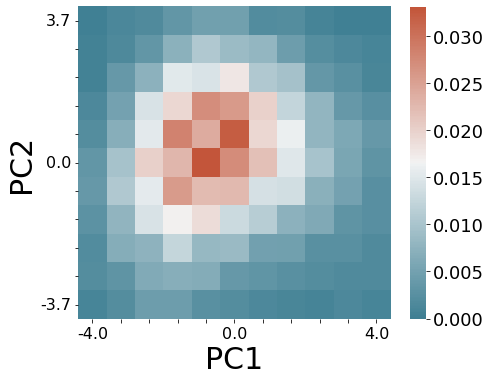

In [4]:
################ heatmap of probability density #############
#calculate the total time observed during the experiment
ttot = transdf.time_elapsed.sum()

#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.sum()/ttot

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    fontsize = 16
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC2', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
#correct axis orientations
ax.invert_yaxis()
# #set title
# ax.set_title('Probability Density (sec)', fontsize = 22)

plt.savefig(savedir + 'PC2_PC2 probability density heatmap.png', bbox_inches='tight')

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


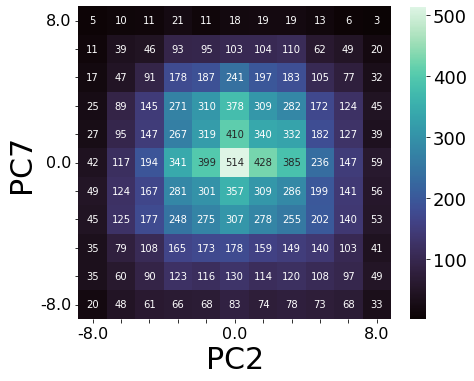

In [37]:
################ PLOT THE COUNTS OF THE BINS #############
#calculate the total time observed during the experiment
ttot = transdf.time_elapsed.sum()

#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = len(current)

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    bighm,
    vmin=np.min(bighm[np.nonzero(bighm)]),
    vmax=bighm.max(), #center=0,
    cmap='mako',#sns.light_palette('#004a27', as_cmap=True),
    square=True,
    xticklabels = True,
    yticklabels = True,
    annot = True,
    fmt = '.0f',
    ax = ax,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    fontsize = 16
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC2', fontsize = 30)
ax.set_ylabel('PC7', fontsize = 30)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
#correct axis orientations
ax.invert_yaxis()
# #set title
# ax.set_title('Probability Density (sec)', fontsize = 22)

plt.savefig(savedir + 'PC2_PC7 transition count heatmap.png', bbox_inches='tight')

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


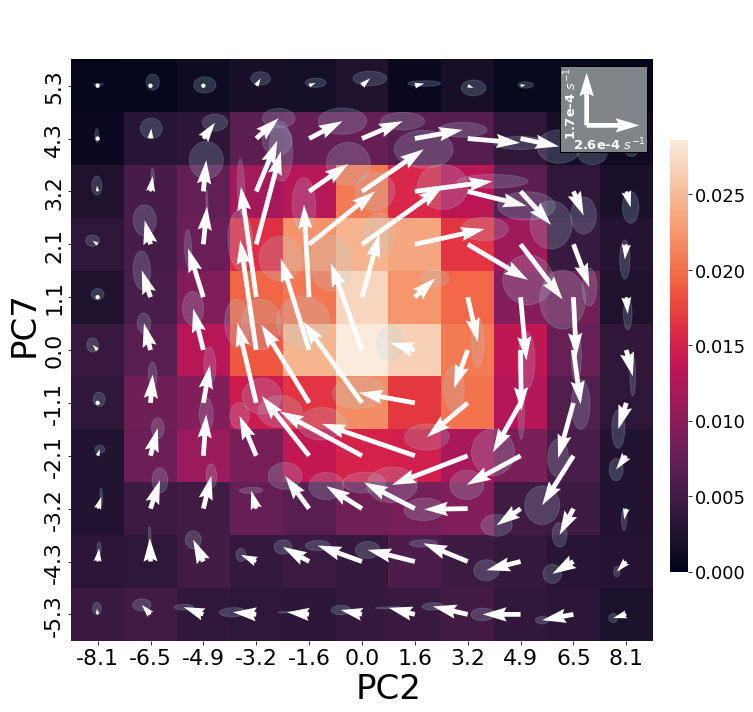

In [17]:
########## PC2/PC7 transition with error ellipses oriented to PCs WITHOUT PC MESH SLICES ################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords


# inverse scale for arrows
scale = 0.0008

# combine fake error data with real transition data
elldf = bsfield_sep.merge(trans_rate_df_sep,left_on = ['x','y'], right_on = ['x','y'])


norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})



fig, ax = plt.subplots(figsize=(10,10))

cbar_ax = fig.add_axes([0.93, .2, .025, .6])


ttot = transdf_sep.time_elapsed.sum()
#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf_sep[(transdf_sep['from_x'] == x+1) & (transdf_sep['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.sum()/ttot
#plot heatmap with seaborn
sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap='rocket',
    square=True,
    xticklabels = True,
    yticklabels = True,
    ax = ax,
#     cbar=i==0,
    cbar_ax = cbar_ax,
#         cbar_kws=cbar_kws
)


    
for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2

        ell = Ellipse(xy=(x-0.5+(xcurrent.values*(1/scale)),y-0.5+(ycurrent.values*(1/scale))),
                width=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1x.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                  height=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1y.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                angle=np.arctan2(current.evec1y,current.evec1x),
                     color = 'lightblue')
        ax.add_artist(ell)
        ell.set_alpha(0.2)

for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
        ax.quiver(x-0.5,
                   y-0.5, 
                   xcurrent,
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = 'white',
                    zorder = 3 * 5)
    

#         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
ax.set_xlabel(f'PC{whichpcs[0]}', fontsize = 34)
ax.set_ylabel(f'PC{whichpcs[1]}', fontsize = 34)
ax.set_xticks(np.arange(0.5,nbins+0.5))
ax.set_xticklabels([round(x,1) for x in centers[f'PC{whichpcs[0]}'].to_list()], fontsize = 22)
ax.set_yticks(np.arange(0.5,nbins+0.5))
ax.set_yticklabels([round(x,1) for x in centers[f'PC{whichpcs[1]}'].to_list()], fontsize = 22)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)
# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)

#legend background
lxp = 9.25
lyp = 9.25
rect = Rectangle((lxp, lyp), 1.645, 1.625, linewidth=1, edgecolor='black', facecolor='#80858a')
ax.add_patch(rect)
rect.set_zorder(4 * 5)
#x-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
#x-axis legend text
xsc = f'{(np.diff(centers[f"PC{whichpcs[0]}"].to_list()).mean()/time_interval)*scale:.1e}'
xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
ax.text(lxp+0.25,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)
#y-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
#y-axis legend text
ysc = f'{(np.diff(centers[f"PC{whichpcs[1]}"].to_list()).mean()/time_interval)*scale:.1e}'
ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
ax.text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)

                  

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
plt.tight_layout()

plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} Vector map and pdf.png', bbox_inches='tight')

In [12]:
centers[f'PC{whichpcs[0]}'].diff().mean()

1.6245656967163087

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


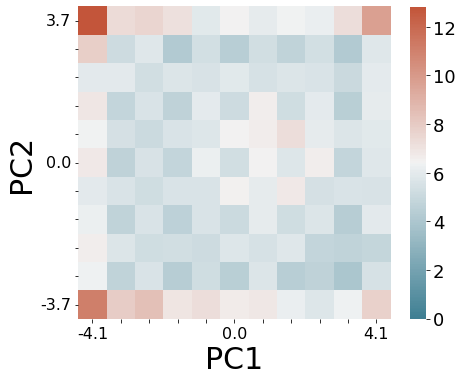

In [14]:
################ heatmap of AVERAGE DWELL TIME #############

#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.mean()

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    fontsize = 16
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC2', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
#correct axis orientations
ax.invert_yaxis()
# #set title
# ax.set_title('Probability Density (sec)', fontsize = 22)

plt.savefig(savedir + 'PC2_PC2 avg dwell time heatmap.png', bbox_inches='tight')

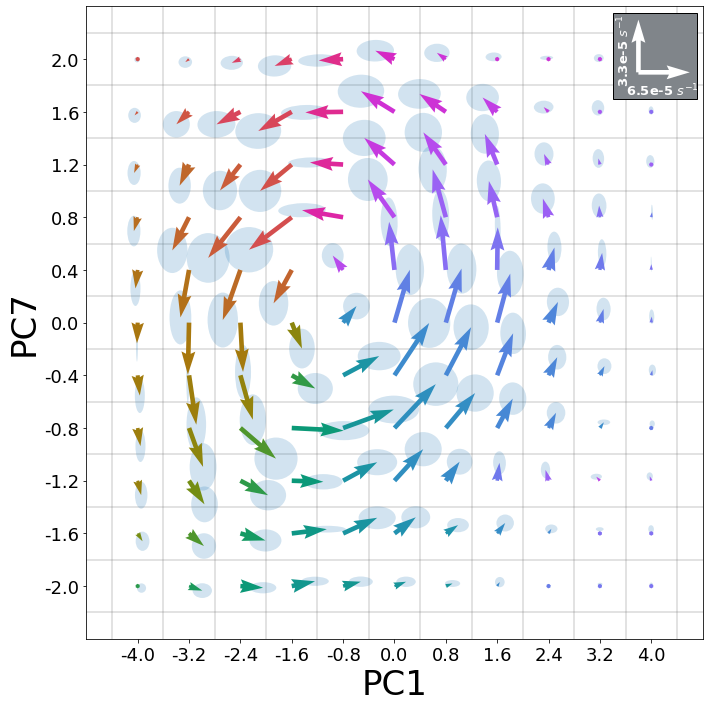

In [7]:
########## PC2/PC7 transition with error ellipses oriented to PCs WITHOUT PC MESH SLICES ################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords


# inverse scale for arrows
scale = 0.0008

# combine fake error data with real transition data
elldf = bsfield_sep.merge(trans_rate_df,left_on = ['x','y'], right_on = ['x','y'])


norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})



fig, ax = plt.subplots(figsize=(10,10))
    

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # vertical lines

    
for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2

        ell = Ellipse(xy=(x+(xcurrent.values*(1/scale)),y+(ycurrent.values*(1/scale))),
                width=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1x.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                  height=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1y.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                angle=np.arctan2(current.evec1y,current.evec1x))
        ax.add_artist(ell)
        ell.set_alpha(0.2)

for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
        ax.quiver(x,
                   y, 
                   xcurrent,
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = cmm(norm(anglecolor)),
                    zorder = 3 * 5)
    

#         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
ax.set_xlabel('PC2', fontsize = 34)
ax.set_ylabel('PC7', fontsize = 34)
ax.set_xticks(list(range(1,nbins+1)),[round(x,1) for x in centers.PC2.to_list()], fontsize = 18)
ax.set_yticks(list(range(1,nbins+1)),[round(x,1) for x in centers.PC7.to_list()], fontsize = 18)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)

#legend background
lxp = 10.25
lyp = 10.25
rect = Rectangle((lxp, lyp), 1.645, 1.625, linewidth=1, edgecolor='black', facecolor='#80858a')
ax.add_patch(rect)
rect.set_zorder(4 * 5)
#x-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
#x-axis legend text
xsc = f'{(np.diff(centers.PC2.to_list()).mean()/time_interval)*scale:.1e}'
xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
ax.text(lxp+0.25,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)
#y-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
#y-axis legend text
ysc = f'{(np.diff(centers.PC7.to_list()).mean()/time_interval)*scale:.1e}'
ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
ax.text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)

                  

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
plt.tight_layout()

plt.savefig(savedir + 'PC2_PC7 Vector map absolute angle colored.png', bbox_inches='tight')

In [11]:
############## bootstrapped AERs #################
from CustomFunctions.DetailedBalance import get_area_enclosing_rate

whichpcs = ['PC1','PC7']
xyscaling = [centers[whichpcs[0]].diff().mean(),centers[whichpcs[1]].diff().mean()]
center = [5,6]

if os.path.exists(savedir+f'PC1-PC7_Area_Enclosing_Rates.csv'):
    allaers = pd.read_csv(savedir+f'PC1-PC7_Area_Enclosing_Rates.csv', index_col=0)
    allaers['Treatment'] = pd.Categorical(allaers.Treatment, categories=['DMSO','CK666'], ordered=True)
    allaers = allaers.sort_values(by='Treatment')
    print('Opened aers')
else:
    start = 0
    stop = 200
    allresults = []

    while start<bstrans.iter.max():
        print(f'Finished {start}, starting {start}-{stop}')
        if __name__ ==  '__main__':
            pool = multiprocessing.Pool(processes=60)
            results = []
            for x in range(start,stop+1):
                b = bstrans[bstrans.iter==x]
                b = b.sort_values('cumulative_time').reset_index(drop = True)
                pool.apply_async(get_area_enclosing_rate, args = (
                    b,
                    nbins,
                    xyscaling,
                    center,
                    ),
                    callback = collect_results)
            pool.close()
            pool.join()

            allresults.extend(results)

            start = stop + 1
            stop = stop + 200
            if stop>bstrans.iter.max():
                stop = bstrans.iter.max()

    allaers = pd.DataFrame()
    allaers['aer'] = [a.aer.sum() for a in allresults]
    allaers['Treatment'] = ['Random']*len(allaers)

    allaers = allaers.reset_index(drop=True)
    allaers.to_csv(savedir+'PC1-PC7_Area_Enclosing_Rates.csv')

Opened aers


In [17]:
p_value

0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-90.70243636152344 0.0


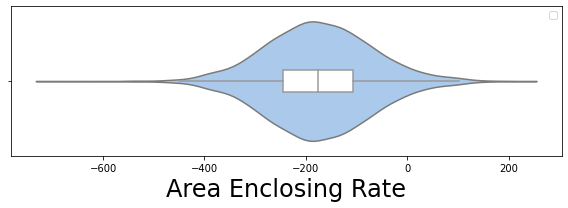

In [21]:
import scipy.stats as stats
t_statistic, p_value = stats.ttest_1samp(a=allaers.aer, popmean=0) 
print(t_statistic , p_value)
################ histograms of the contour integral distributions ###########

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


fig, ax = plt.subplots(figsize=(8,3))#, sharex=True)
#plots
sns.violinplot(data=allaers, x = 'aer',
               palette = colorlist, inner = None, ax=ax)
sns.boxplot(data=allaers,x='aer', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, 
            ax=ax)

#labelste
ax.set_xlabel('Area Enclosing Rate', fontsize=24)#, labelpad=-5)
ax.set_ylabel('', fontsize=20)
ax.tick_params('y', labelsize=16)
ax.set_yticklabels([''], fontsize = 14)
# ax.text(255,0,'***',fontdict= {'fontsize': 22,
#                                'horizontalalignment':'center'})


plt.legend()
plt.tight_layout()

plt.savefig(savedir + f'alldata aer.png', bbox_inches='tight', dpi = 500)


In [20]:
######### do contour integrals ################
from CustomFunctions.DetailedBalance import contour_integral

uple = [3,8]
lori = [8,3]
if os.path.exists(savedir+f'Contour_integrals_uple{uple}_lori{lori}.csv'):
    omegas = pd.read_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}.csv', index_col=0)
else:
    omegas = []
    for b in bslist:
        omegas.append(contour_integral(b, uple, lori, norm = False))
    omegas = pd.DataFrame(list(zip(omegas/pd.Series(omegas).std(),['omega']*len(omegas))), columns=['Norm_Omegas','sample'])
    omegas.to_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv')

In [14]:
################ histograms of the contour integral distributions ###########


colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


fig, ax = plt.subplots(figsize=(4,8))#, sharex=True)
#plots
sns.violinplot(data=omegas, y = 'Norm_Omegas',
               palette = colorlist, inner = None, ax=ax)
sns.boxplot(data=omegas,y='Norm_Omegas', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, 
            ax=ax)

#labels
ax.set_ylabel('$Ω/σ_{Ω}$', fontsize=30, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=14)
ax.set_xticklabels([''], fontsize = 14)



plt.legend()
plt.tight_layout()

plt.savefig(savedir + f'contour integral of uple{uple} and lori{lori}.png', bbox_inches='tight', dpi = 500)


NameError: name 'data' is not defined

In [22]:
######### do NORMALIZED contour integrals ################
from CustomFunctions.DetailedBalance import contour_integral

uple = [3,8]
lori = [8,4]
if os.path.exists(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv'):
    omegas_norm = pd.read_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv', index_col=0)
else:
    omegas = []
    for b in bslist:
        omegas.append(contour_integral(b, uple, lori, norm = True))
    omegas_norm = pd.DataFrame(list(zip(omegas/pd.Series(omegas).std(),['omega']*len(omegas))), columns=['Norm_Omegas','sample'])
    omegas_norm.to_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv')

(210.32165930822035, 0.0)


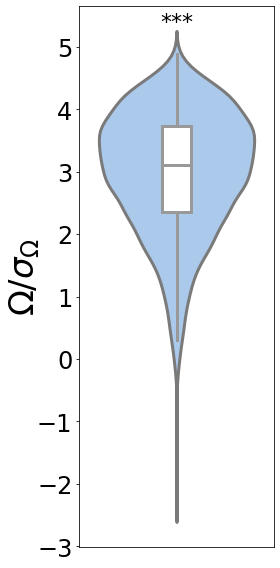

In [38]:
################ histograms of the contour integral distributions ###########
from statsmodels.stats.weightstats import ztest as ztest
colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


fig, ax = plt.subplots(figsize=(4,8))#, sharex=True)
#plots
sns.violinplot(data=omegas_norm, y = 'Norm_Omegas',
               palette = colorlist, linewidth = 3, inner = None, ax=ax)
sns.boxplot(data=omegas_norm,y='Norm_Omegas', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, linewidth = 3, boxprops={'zorder': 2}, 
            ax=ax)

#labels
ax.set_ylabel('$Ω/σ_{Ω}$', fontsize=34, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=24)
ax.set_xticklabels([''], fontsize = 14)
ax.set_xticks([])

ax.text(0,5.3,'***',fontdict= {'fontsize': 22,
                               'horizontalalignment':'center'})
plt.tight_layout()

plt.savefig(savedir + f'contour integral of uple{uple} and lori{lori} normalized.png', bbox_inches='tight', dpi = 500)
print(str(ztest(omegas_norm.Norm_Omegas, value=0)))